### Wire cutting as a method to improve performance of quantum circuits

Circuit-knitting is an umbrella term which encapsulates various methods of partitioning a circuit in multiple smaller subcircuits involving fewer gates and/or qubits. Each of the subcircuits can be executed independently and the final result is obtained via some classical postprocessing over the outcome of each subcircuit.

This notebook deals with a method called <b>wire cutting</b> where the circuit is partitioned along the wire [1,2]. Note that, partitioning is simple in classical circuits since the outcome at the point of partition can be determined deterministically, and is either 0 or 1. However, the state of the qubit at the point of the cut is, in general, a mixed state. Therefore, each subcircuit needs to be measured multiple times in different basis (usually a tomographically complete set of basis such as the Pauli basis [3,4]) and correspondingly prepared in its eigenstate. The Figure below (<i>courtesy: PhD Thesis, Ritajit Majumdar</i>) shows an example of wire cutting for a 4-qubit GHZ state into three subcircuits. Here $M_j$ denote a set of basis (usually Pauli X, Y and Z) and $P_i$ denote a set of eigenstates (usually $|0\rangle$, $|1\rangle$, $|+\rangle$ and $|+i\rangle$).

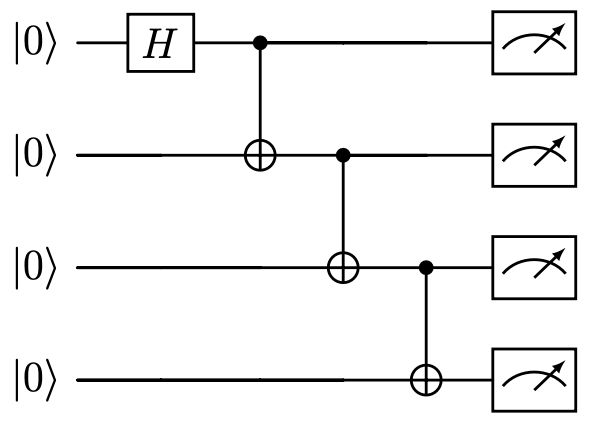
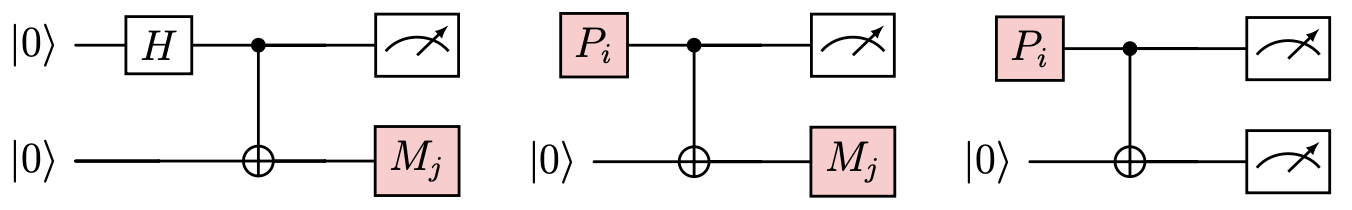

Since each subcircuit has fewer qubits and/or gates, they are expected to be less amenable to noise. This notebook shows an example where this method can be used to effectively suppress the noise in the system.

### Start

We shall take a $p=2$ QAOA circuit as an example for this notebook.

### Build

Here we show the function to build a QAOA circuit, and assign parameters to it. Initial parameters are assigned randomly.

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from numpy.random import default_rng
from numpy import pi

def build_qaoa_circuit(
    num_qubits: int,
    depth: int, # here the convention is depth=2*p
    ):
    gammas = ParameterVector('γ', depth // 2) 
    betas = ParameterVector('β', depth // 2)

    circuit = QuantumCircuit(num_qubits)
    circuit.h(range(num_qubits))
    for layer in range(depth // 2):
        for qubit in range(0, num_qubits - 1, 2):
            circuit.rzz(gammas[layer], qubit, qubit + 1)
        for qubit in range(1, num_qubits - 1, 2):
            circuit.rzz(gammas[layer], qubit, qubit + 1)
        for qubit in range(num_qubits):
            circuit.rx(betas[layer], qubit)

    return circuit

def produce_qaoa_parameters(num_layers, seed=None):
    rng = default_rng(seed=seed)
    betas = rng.uniform(-pi, pi, size=num_layers).tolist()
    gammas = rng.uniform(-pi, pi, size=num_layers).tolist()

    params = []
    for idx in range(len(betas)):
        params.append(gammas[idx])
        params.append(betas[idx])
    return params

Here we show an example of a 20 qubit $p=2$ QAOA circuit.

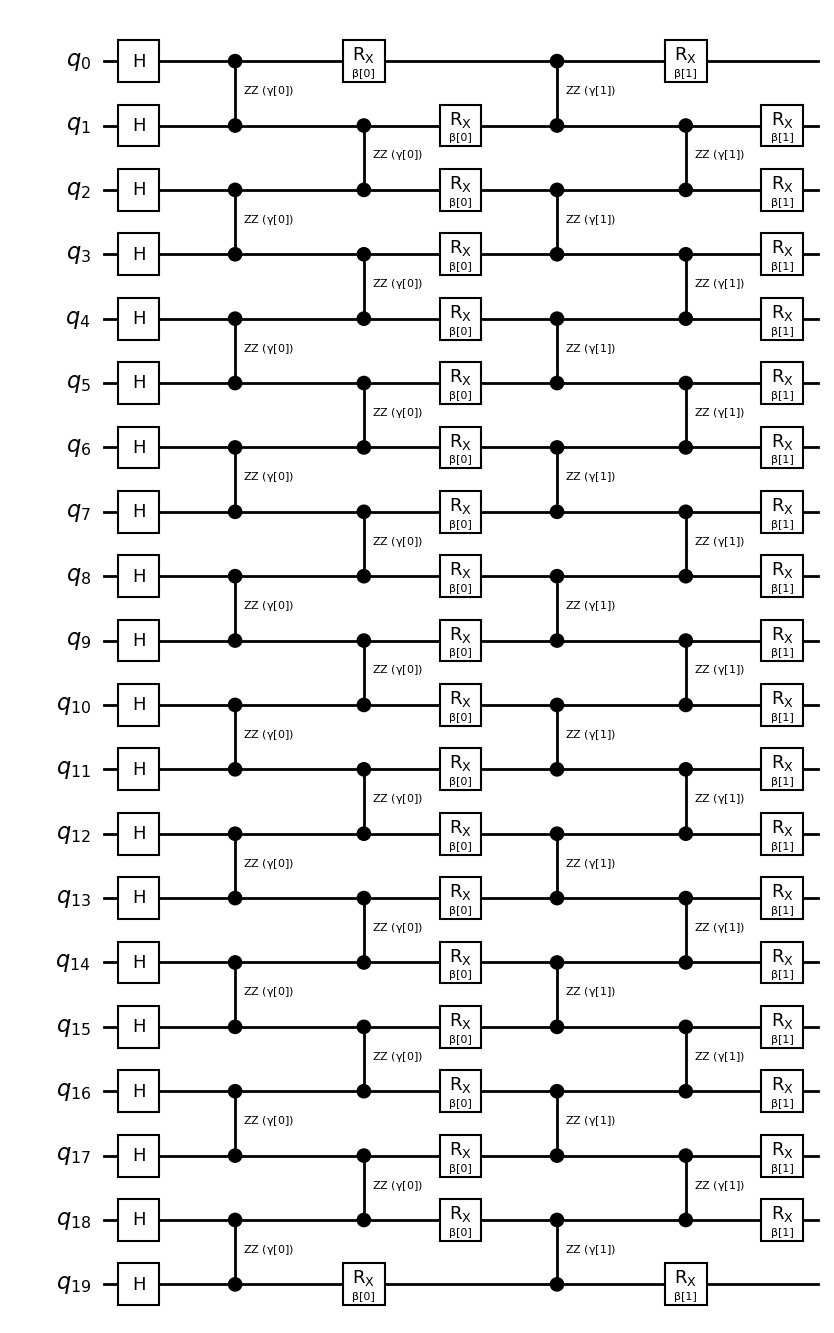

In [2]:
num_qubits = 20
p = 2
qaoa = build_qaoa_circuit(num_qubits,2*p)
qaoa.draw('mpl', style='bw')

### Optimize

#### Cut the circuit into smaller subcircuits

Next we cut the circuit into two smaller subcircuits. For this example, we stick to only 2 subcircuits. For this, we use the <a href="https://qiskit-extensions.github.io/circuit-knitting-toolbox/index.html">Circuit Knitting Toolbox</a> from Qiskit Ecosystem. In particular, for this notebook we shall use the CutQc method to automatically find the cut location [2].

Before running this notebook, it is necessary to install the Circuit Knitting Toolbox. This can be done simply by executing

<i>pip install circuit_knitting_toolbox['cplex']</i>

This installs the free version of CPLEX as well which is required for automated circuit cutting used below. For bigger circuits, involving many cuts, the free version of CPLEX may not be sufficient.

Here we assign the maximum number of subcircuits to 2, and the maximum width of each subcircuit is set to num_qubits/2 + 2, i.e., each subcircuit should be roughly equal in size. The authors can refer to the <a href="https://qiskit-extensions.github.io/circuit-knitting-toolbox/circuit_cutting/cutqc/tutorials/tutorial_1_automatic_cut_finding.html">How-to guides</a> on Circuit Knitting Toolbox for more information on this.

In [3]:
from math import ceil
from circuit_knitting.cutting.cutqc import cut_circuit_wires

cuts = cut_circuit_wires(
    circuit=qaoa,
    method="automatic",
    max_subcircuit_width=ceil(qaoa.num_qubits/2) + 2,
    max_cuts=3,
    num_subcircuits=[2],
    verbose=False
)

Exporting as a LP file to let you check the model that will be solved :  inf <class 'float'>
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               300
Tried aggregator 3 times.
MIP Presolve eliminated 37 rows and 8 columns.
MIP Presolve modified 7 coefficients.
Aggregator did 271 substitutions.
Reduced MIP has 1086 rows, 367 columns, and 3167 nonzeros.
Reduced MIP has 361 binaries, 6 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (5.37 ticks)
Probing time = 0.00 sec. (2.83 ticks)
Cover probing fixed 0 vars, tightened 2 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 0 rows and 106 columns.
Reduced MIP has 1086 rows, 261 columns, and 3167 nonzeros.
Reduced MIP has 255 binaries, 6 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.00 ticks)
Probing time = 0.00 sec. (2.04 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 0 

##### We can check the two subcircuits produced by this method, and note that each of them have fewer qubit and gate count

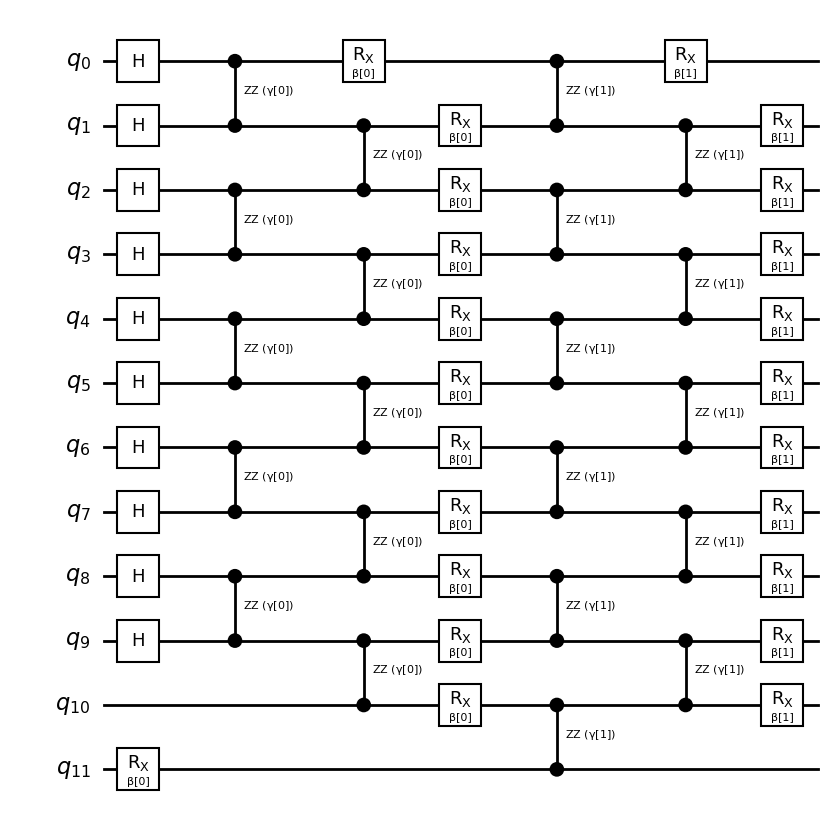

In [4]:
cuts['subcircuits'][0].draw('mpl',style='bw')

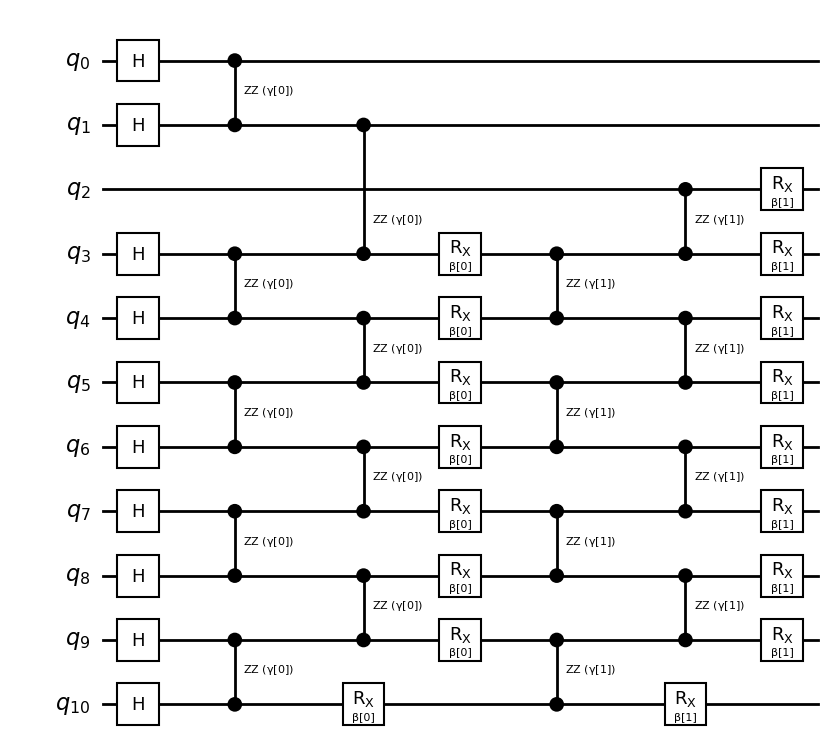

In [5]:
cuts['subcircuits'][1].draw('mpl',style='bw')

### Run and postprocess

For this notebook, we aim to find the expectation value of the observable $\sum_{(i,j) \in edge}Z_i Z_j$. This expectation value is proportional to the Max-Cut value of the QAOA upto some constant terms [5]. The lower is the value, the better it is.

We initialize the initial set of parameters to some random value. We shall use these same initial parameters for noisy and cut versions as well.

Note that due to the iterative method of QAOA, the run and postprocess steps are shown together. For each step, the circuit is executed, and the postprocessing step (i) calculates the expectation value for the observable, and in case of cutting (ii) merges the outcomes of different subcircuits.

In [7]:
from scipy.optimize import minimize

init_params = produce_qaoa_parameters(p, seed=0)

In [12]:
from qiskit_ibm_runtime import Estimator, Sampler, Options, Session, QiskitRuntimeService
from qiskit.quantum_info import SparsePauliOp

options = Options()
options.execution.shots=4000

observable = SparsePauliOp(['I'*i + 'ZZ' + 'I'*(num_qubits-i-2) for i in range(num_qubits-1)])
observableobservable = SparsePauliOp(['I'*i + 'ZZ' + 'I'*(num_qubits-i-2) for i in range(num_qubits-1)])
observable

SparsePauliOp(['ZZIIIIIIIIIIIIIIIIII', 'IZZIIIIIIIIIIIIIIIII', 'IIZZIIIIIIIIIIIIIIII', 'IIIZZIIIIIIIIIIIIIII', 'IIIIZZIIIIIIIIIIIIII', 'IIIIIZZIIIIIIIIIIIII', 'IIIIIIZZIIIIIIIIIIII', 'IIIIIIIZZIIIIIIIIIII', 'IIIIIIIIZZIIIIIIIIII', 'IIIIIIIIIZZIIIIIIIII', 'IIIIIIIIIIZZIIIIIIII', 'IIIIIIIIIIIZZIIIIIII', 'IIIIIIIIIIIIZZIIIIII', 'IIIIIIIIIIIIIZZIIIII', 'IIIIIIIIIIIIIIZZIIII', 'IIIIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIIIIIIZZII', 'IIIIIIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIIIIIIIZZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j])

In [9]:
def calculate_expval(params, circuit, estimator, layout):
    if circuit.num_clbits == 0:
        circuit.measure_active()

    circuit = circuit.assign_parameters(params)
    circuit = trans

    global observable

    expval = estimator.run(circuit, observable).result().values[0]

    return expval

#### QAOA without circuit cutting

First we run the QAOA without circuit cutting. The resilience_level is set to 0 to avoid any mitigation. This ensures that any improvement obtained using circuit cutting is not coming from better mitigation.

In [13]:
service = QiskitRuntimeService()
backend = service.get_backend('ibm_auckland')
options.resilience_level = 0

In [14]:
with Session(backend=backend):
    estimator = Estimator(options=options)
    res = minimize(
        calculate_expval, init_params, args=(qaoa.copy(),estimator), method="cobyla", options={'maxiter':10}
    )

In [15]:
res

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -4.9565
       x: [-3.638e+00  3.592e-01 -1.856e+00 -2.135e+00]
    nfev: 10
   maxcv: 0.0

#### QAOA with circuit cutting

Next, we use wire cutting to cut the qaoa ansatz into two subcircuits. Each of these subcircuits are executed independently, and the results from them are combined classically. In this notebook, we use the same hardware to run both the subcircuits sequentially. However, they can be executed on two different hardware, thus parallelizing the process [6,7].

Note that, in this approach the two distributions are combined classically, and not two expectation values. Therefore, for this approach, we shall use the sampler, and manually calculate the expectation value from the count distribution as a postprocessing step.

In [16]:
from circuit_knitting.cutting.cutqc import evaluate_subcircuits
from circuit_knitting.cutting.cutqc import reconstruct_full_distribution
from qiskit.result import sampled_expectation_value

def calculate_cut_expval(params, circuit):
    global service
    circuit = circuit.assign_parameters(params)

    cuts = cut_circuit_wires(
        circuit=circuit,
        method="automatic",
        max_subcircuit_width=ceil(circuit.num_qubits/2) + 2,
        max_cuts=3,
        num_subcircuits=[2],
        verbose=False
    )

    subcircuit_instance_probabilities = evaluate_subcircuits(cuts,
                                                         service=service,
                                                         backend_names=['ibm_auckland']*2,
                                                         options=options,
                                                        )
    reconstructed_probabilities = reconstruct_full_distribution(
        circuit, subcircuit_instance_probabilities, cuts
    )

    prob_dict = {}

    for idx, prob in enumerate(reconstructed_probabilities):
        prob_dict[bin(idx)[2:].zfill(circuit.num_qubits)] = prob

    global observable
    expval = sampled_expectation_value(prob_dict, observable)

    return expval

In [17]:
res = minimize(
    calculate_cut_expval, init_params, args=(qaoa.copy()), method="cobyla", options={'maxiter':10}
)

Exporting as a LP file to let you check the model that will be solved :  inf <class 'float'>
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               300
Tried aggregator 3 times.
MIP Presolve eliminated 37 rows and 8 columns.
MIP Presolve modified 7 coefficients.
Aggregator did 271 substitutions.
Reduced MIP has 1086 rows, 367 columns, and 3167 nonzeros.
Reduced MIP has 361 binaries, 6 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (5.37 ticks)
Probing time = 0.00 sec. (2.83 ticks)
Cover probing fixed 0 vars, tightened 2 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 0 rows and 106 columns.
Reduced MIP has 1086 rows, 261 columns, and 3167 nonzeros.
Reduced MIP has 255 binaries, 6 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.00 ticks)
Probing time = 0.00 sec. (2.04 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 0 

In [18]:
res

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -6.292421124586673
       x: [-3.778e+00 -2.192e-01 -2.178e+00 -2.589e+00]
    nfev: 10
   maxcv: 0.0

### Inference

Recall that the observable was selected from the Max-Cut problem, and lower the value of the objective function, the better it is. We observe that after 10 steps of iteration, the uncut QAOA reached an objective function of -4.9565 whereas the cut QAOA reached -6.2924. This shows that cutting itself can suppress the effect of noise.

Note that it is possible to use other error suppression and mitigation methods together with circuit cutting to further improve the performance. Moreover, in this notebook, we computed both the subcircuits on the same hardware. In [7], the authors shows a method to distribute the subcircuits on different hardware using noise information in order to maximize the noise suppression, and parallelize the process.

<b>Word of caution</b>

The postprocessing time scales exponentially with the number of cuts. Therefore, while many cuts can produce small subcircuits, thus further improving the performance, it also leads to a significantly high postprocessing time, which may not be practical for most cases. Therefore, circuit cutting should be used only when the number of cuts is small.

<b>References</b>

<ol>
  <li>Peng, T., Harrow, A. W., Ozols, M., & Wu, X. (2020). Simulating large quantum circuits on a small quantum computer. Physical review letters, 125(15), 150504.</li>
  <li>Tang, W., Tomesh, T., Suchara, M., Larson, J., & Martonosi, M. (2021, April). Cutqc: using small quantum computers for large quantum circuit evaluations. In Proceedings of the 26th ACM International conference on architectural support for programming languages and operating systems (pp. 473-486).</li>
  <li>Perlin, M. A., Saleem, Z. H., Suchara, M., & Osborn, J. C. (2021). Quantum circuit cutting with maximum-likelihood tomography. npj Quantum Information, 7(1), 64.</li>
  <li>Majumdar, R., & Wood, C. J. (2022). Error mitigated quantum circuit cutting. arXiv preprint arXiv:2211.13431.</li>
  <li>Farhi, E., Goldstone, J., & Gutmann, S. (2014). A quantum approximate optimization algorithm. arXiv preprint arXiv:1411.4028.</li>
  <li>Khare, T., Majumdar, R., Sangle, R., Ray, A., Seshadri, P. V., & Simmhan, Y. (2023). Parallelizing Quantum-Classical Workloads: Profiling the Impact of Splitting Techniques. In 2023 IEEE International Conference on Quantum Computing and Engineering (QCE) (Vol. 1, pp. 990-1000). IEEE.</li>
  <li>Bhoumik, D., Majumdar, R., Saha, A., & Sur-Kolay, S. (2023). Distributed Scheduling of Quantum Circuits with Noise and Time Optimization. arXiv preprint arXiv:2309.06005.</li>
</ol>

In [20]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright